In [1]:
# Cell 1: Install Required Libraries + Memory Optimization
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'max_split_size_mb:64'
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'
!pip install -q transformers datasets torch accelerate evaluate rouge-score nltk

print("Memory optimization environment variables set!")

Memory optimization environment variables set!


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Cell 2: Import All Required Libraries
import os
import torch
import pandas as pd
import numpy as np
import json
from datasets import Dataset, DatasetDict
from transformers import (
    T5Tokenizer,
    T5ForConditionalGeneration,
    TrainingArguments,
    Trainer,
    DataCollatorForSeq2Seq
)
from evaluate import load
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import warnings
warnings.filterwarnings('ignore')
# Download NLTK data for sentence tokenization
nltk.download('punkt', quiet=True)
print("All libraries imported successfully!")

All libraries imported successfully!


In [3]:
# Cell 3: Check GPU Availability
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    print(f"CUDA Version: {torch.version.cuda}")
else:
    print("No GPU available. Training will be slower on CPU.")

Using device: cpu
No GPU available. Training will be slower on CPU.


In [5]:
# Cell 4: Load Pre-Split Dataset Files (Train, Validation, Test)
import glob
# Defining dataset folder path
dataset_folder = "/content/drive/MyDrive/Colab Notebooks/Project_02/Task_03_Encoder&Decoder/dataset"
# Find all CSV files
csv_files = glob.glob(os.path.join(dataset_folder, "*.csv"))
print(f"Found CSV files: {csv_files}")
# Load the three splits
train_df = pd.read_csv(os.path.join(dataset_folder, "train.csv"))
val_df   = pd.read_csv(os.path.join(dataset_folder, "validation.csv"))
test_df  = pd.read_csv(os.path.join(dataset_folder, "test.csv"))
print("\nDatasets loaded successfully!")
print(f"Train shape: {train_df.shape}")
print(f"Validation shape: {val_df.shape}")
print(f"Test shape: {test_df.shape}")
print(f"\nColumns: {train_df.columns.tolist()}")

Found CSV files: ['/content/drive/MyDrive/Colab Notebooks/Project_02/Task_03_Encoder&Decoder/dataset/test.csv', '/content/drive/MyDrive/Colab Notebooks/Project_02/Task_03_Encoder&Decoder/dataset/train.csv', '/content/drive/MyDrive/Colab Notebooks/Project_02/Task_03_Encoder&Decoder/dataset/validation.csv']

Datasets loaded successfully!
Train shape: (287113, 3)
Validation shape: (13368, 3)
Test shape: (11490, 3)

Columns: ['id', 'article', 'highlights']


In [6]:
# Cell 5: Explore the Training Dataset
print("DATASET EXPLORATION (Training Set Example)")
print("\n Dataset Info:")
print(train_df.info())
print("\nFirst 2 rows (truncated):")
for idx in range(min(2, len(train_df))):
    print(f"\nRow {idx+1}:")
    for col in train_df.columns:
        value = str(train_df.iloc[idx][col])
        print(f"  {col}: {value[:150]}{'...' if len(value) > 150 else ''}")
print(f"\nMissing values:")
print(train_df.isnull().sum())


DATASET EXPLORATION (Training Set Example)

 Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287113 entries, 0 to 287112
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   id          287113 non-null  object
 1   article     287113 non-null  object
 2   highlights  287113 non-null  object
dtypes: object(3)
memory usage: 6.6+ MB
None

First 2 rows (truncated):

Row 1:
  id: 0001d1afc246a7964130f43ae940af6bc6c57f01
  article: By . Associated Press . PUBLISHED: . 14:11 EST, 25 October 2013 . | . UPDATED: . 15:36 EST, 25 October 2013 . The bishop of the Fargo Catholic Diocese...
  highlights: Bishop John Folda, of North Dakota, is taking time off after being diagnosed .
He contracted the infection through contaminated food in Italy .
Church...

Row 2:
  id: 0002095e55fcbd3a2f366d9bf92a95433dc305ef
  article: (CNN) -- Ralph Mata was an internal affairs lieutenant for the Miami-Dade Police Department, working

In [7]:
# Cell 6: Identify and Standardize Column Names
print("IDENTIFYING DATASET STRUCTURE")
sample_df = train_df.copy()
article_col = None
summary_col = None
for col in sample_df.columns:
    col_lower = col.lower()
    if any(x in col_lower for x in ['article', 'text', 'document', 'content']):
        article_col = col
    elif any(x in col_lower for x in ['summary', 'highlight', 'abstract']):
        summary_col = col
print(f"Identified columns:")
print(f"  Article column: {article_col}")
print(f"  Summary column: {summary_col}")
if not all([article_col, summary_col]):
    print("\nWarning: Could not auto-detect all columns.")
    print("Available columns:", sample_df.columns.tolist())

IDENTIFYING DATASET STRUCTURE
Identified columns:
  Article column: article
  Summary column: highlights


In [8]:
# Cell 7: Data Cleaning and Preprocessing
print("DATA PREPROCESSING")
def clean_dataset(df):
    df_clean = df[[article_col, summary_col]].copy()
    df_clean = df_clean.dropna()
    df_clean.columns = ['article', 'summary']
    df_clean['article'] = df_clean['article'].astype(str)
    df_clean['summary'] = df_clean['summary'].astype(str)
    df_clean = df_clean.drop_duplicates(subset=['article'])
    return df_clean.reset_index(drop=True)
train_df = clean_dataset(train_df)
val_df   = clean_dataset(val_df)
test_df  = clean_dataset(test_df)
print("After cleaning:")
print(f"  Train size: {len(train_df)}")
print(f"  Validation size: {len(val_df)}")
print(f"  Test size: {len(test_df)}")

DATA PREPROCESSING
After cleaning:
  Train size: 284005
  Validation size: 13368
  Test size: 11488


TEXT LENGTH ANALYSIS (Train Set - Memory Safe)
Analyzed sample of 3000 rows out of 284005 total.

Article Length Statistics:
count    3000.000000
mean      689.953667
std       335.989510
min        58.000000
25%       438.750000
50%       634.000000
75%       880.000000
max      1890.000000
Name: article_words, dtype: float64

Summary Length Statistics:
count    3000.000000
mean       51.411000
std        20.686906
min         8.000000
25%        38.000000
50%        48.000000
75%        60.000000
max       216.000000
Name: summary_words, dtype: float64

Compression Ratio Statistics:
count    3000.000000
mean        0.091038
std         0.053616
min         0.007387
25%         0.053997
50%         0.077714
75%         0.114512
max         0.758621
Name: compression_ratio, dtype: float64


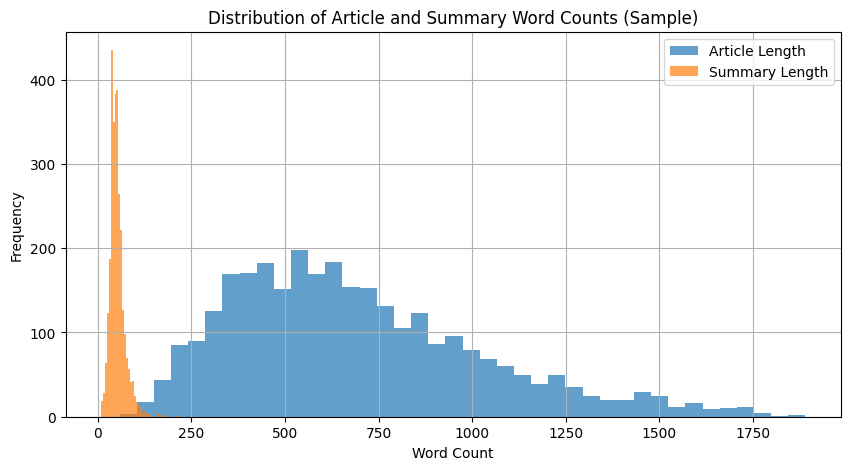

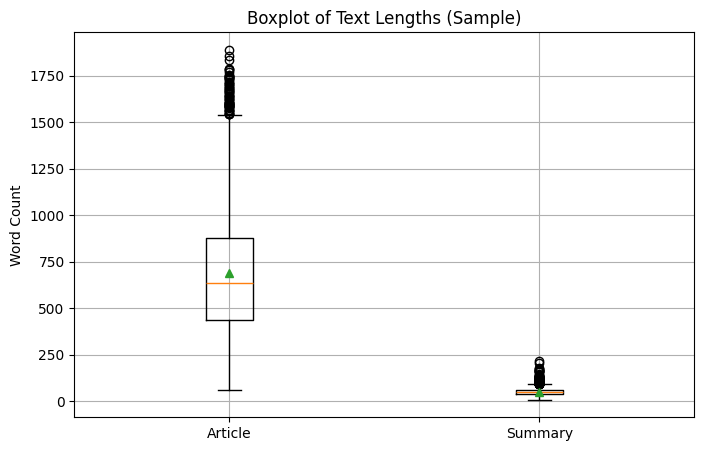

In [11]:
# Cell 8: Memory-Safe Text Length Analysis (Sample)
print("TEXT LENGTH ANALYSIS (Train Set - Memory Safe)")
# Sample a subset to overcome crash problem
sample_size = min(3000, len(train_df))
df_sample = train_df.sample(sample_size, random_state=42).copy()
# Compute word counts efficiently
df_sample['article_words'] = df_sample['article'].apply(lambda x: len(str(x).split()))
df_sample['summary_words'] = df_sample['summary'].apply(lambda x: len(str(x).split()))
df_sample['compression_ratio'] = df_sample['summary_words'] / df_sample['article_words']
print(f"Analyzed sample of {sample_size} rows out of {len(train_df)} total.\n")
print("Article Length Statistics:")
print(df_sample['article_words'].describe())
print("\nSummary Length Statistics:")
print(df_sample['summary_words'].describe())
print("\nCompression Ratio Statistics:")
print(df_sample['compression_ratio'].describe())
# Visualization (safe)
plt.figure(figsize=(10, 5))
plt.hist(df_sample['article_words'], bins=40, alpha=0.7, label='Article Length')
plt.hist(df_sample['summary_words'], bins=40, alpha=0.7, label='Summary Length')
plt.title("Distribution of Article and Summary Word Counts (Sample)")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()
plt.figure(figsize=(8, 5))
plt.boxplot(
    [df_sample['article_words'], df_sample['summary_words']],
    labels=['Article', 'Summary'],
    showmeans=True
)
plt.title("Boxplot of Text Lengths (Sample)")
plt.ylabel("Word Count")
plt.grid(True)
plt.show()

In [9]:
# Cell 9: Sample Dataset for Training
SAMPLE_SIZE = 2500
if len(train_df) > SAMPLE_SIZE:
    train_df = train_df.sample(n=SAMPLE_SIZE, random_state=42).reset_index(drop=True)
    print(f"\nUsing sample of {SAMPLE_SIZE} articles for training")
else:
    print(f"\nUsing full dataset of {len(train_df)} articles")


Using sample of 2500 articles for training


In [10]:
# Cell 10: Display Sample Article and Summary
print("SAMPLE ARTICLE AND SUMMARY")
sample_idx = 0
print(f"\nARTICLE (first 500 characters):")
print(train_df['article'].iloc[sample_idx][:500] + "...")
print(f"\nORIGINAL SUMMARY:")
print(train_df['summary'].iloc[sample_idx])
print(f"\nStatistics:")
print(f"  Article words: {len(train_df['article'].iloc[sample_idx].split())}")
print(f"  Summary words: {len(train_df['summary'].iloc[sample_idx].split())}")
print(f"  Compression: {len(train_df['summary'].iloc[sample_idx].split()) / len(train_df['article'].iloc[sample_idx].split()):.2%}")

SAMPLE ARTICLE AND SUMMARY

ARTICLE (first 500 characters):
They say diamonds are a girl's best friend -- especially if they're flawless, vivid blue and 13.22 carats! But to get acquainted with this particular bit of bling, you'll need a cool £13.5 million to spare. 'The Blue', the largest flawless vivid . blue diamond in the world, is the centrepiece of the annual Christie's Magnificent Jewels sale taking place at the Four Seasons Hotel des Bergues in Geneva next month. Scroll down for video . Start saving!: The largest flawless vivid blue diamond in th...

ORIGINAL SUMMARY:
The rare coloured stone is being sold by auction house Christie's .
Stone weighs a whopping 13.22 carats .
The auction's 250 lots are expected to make a staggering £47.5 million .

Statistics:
  Article words: 433
  Summary words: 32
  Compression: 7.39%


In [11]:
# Cell 11 & 12: Use Provided Splits Directly
print("USING PROVIDED DATA SPLITS")
from datasets import Dataset, DatasetDict
train_dataset = Dataset.from_pandas(train_df)

# Sample validation and test sets to reduce memory usage
VAL_SAMPLE_SIZE = 200 # Further reduced validation sample size
TEST_SAMPLE_SIZE = 100 # Reduced test sample size significantly

val_df_sampled = val_df.sample(n=min(VAL_SAMPLE_SIZE, len(val_df)), random_state=42).reset_index(drop=True)
test_df_sampled = test_df.sample(n=min(TEST_SAMPLE_SIZE, len(test_df)), random_state=42).reset_index(drop=True)

val_dataset   = Dataset.from_pandas(val_df_sampled)
test_dataset  = Dataset.from_pandas(test_df_sampled)

dataset_dict = DatasetDict({
    'train': train_dataset,
    'validation': val_dataset,
    'test': test_dataset
})
print("DatasetDict created using pre-split CSV files:")
print(dataset_dict)

USING PROVIDED DATA SPLITS
DatasetDict created using pre-split CSV files:
DatasetDict({
    train: Dataset({
        features: ['article', 'summary'],
        num_rows: 2500
    })
    validation: Dataset({
        features: ['article', 'summary'],
        num_rows: 200
    })
    test: Dataset({
        features: ['article', 'summary'],
        num_rows: 100
    })
})


In [12]:
# Cell 13: Load T5 Tokenizer
print("LOADING T5 TOKENIZER")
model_name = 't5-small'
tokenizer = T5Tokenizer.from_pretrained(model_name)
print(f"Tokenizer: {model_name}")
print(f"Vocabulary size: {tokenizer.vocab_size}")
print(f"Model max length: {tokenizer.model_max_length}")
# Test tokenization with sample
sample_text = "summarize: " + train_df['article'].iloc[0][:200]
print(f"\nExample tokenization:")
print(f"Input: {sample_text[:100]}...")
encoded = tokenizer(sample_text, truncation=True, max_length=50)
print(f"Tokens: {len(encoded['input_ids'])} tokens")
print(f"First 20 token IDs: {encoded['input_ids'][:20]}")

LOADING T5 TOKENIZER


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


Tokenizer: t5-small
Vocabulary size: 32000
Model max length: 512

Example tokenization:
Input: summarize: They say diamonds are a girl's best friend -- especially if they're flawless, vivid blue ...
Tokens: 50 tokens
First 20 token IDs: [21603, 10, 328, 497, 7097, 7, 33, 3, 9, 3202, 31, 7, 200, 1565, 1636, 902, 3, 99, 79, 31]


In [13]:
# Cell 14: Define Preprocessing Function with Task Prefix (MEMORY-SMALL)
print("CONFIGURING TOKENIZATION (memory-small)")
# Set maximum lengths for input and output (reduced further)
MAX_INPUT_LENGTH = 128   # <- reduced from 195
MAX_TARGET_LENGTH = 32   # <- reduced from 48
print(f"Max input (article) length: {MAX_INPUT_LENGTH} tokens")
print(f"Max target (summary) length: {MAX_TARGET_LENGTH} tokens")
def preprocess_function(examples):
    # Add task prefix to inputs
    inputs = ["summarize: " + doc for doc in examples['article']]
    # Tokenize inputs
    model_inputs = tokenizer(
        inputs,
        max_length=MAX_INPUT_LENGTH,
        truncation=True,
        padding='max_length'   # keep fixed-length padding for stable shapes
    )
    # Tokenize targets (summaries)
    labels = tokenizer(
        examples['summary'],
        max_length=MAX_TARGET_LENGTH,
        truncation=True,
        padding='max_length'
    )
    # Replace pad token id's in labels if needed later by Trainer (Trainer uses -100)
    model_inputs['labels'] = labels['input_ids']
    return model_inputs
print("Preprocessing function defined (shorter max lengths).")

CONFIGURING TOKENIZATION (memory-small)
Max input (article) length: 128 tokens
Max target (summary) length: 32 tokens
Preprocessing function defined (shorter max lengths).


In [14]:
# Cell 15: Tokenize All Datasets (memory safe)
print("TOKENIZING DATASETS (memory safe mode)")
# Use small internal batch_size for map to keep memory low while tokenizing
MAP_BATCH_SIZE = 128
# Tokenize train (do NOT create huge caches in memory)
tokenized_train = dataset_dict['train'].map(
    preprocess_function,
    batched=True,
    batch_size=MAP_BATCH_SIZE,
    remove_columns=['article', 'summary'],
    load_from_cache_file=False,
    desc="Tokenizing train"
)
tokenized_val = dataset_dict['validation'].map(
    preprocess_function,
    batched=True,
    batch_size=MAP_BATCH_SIZE,
    remove_columns=['article', 'summary'],
    load_from_cache_file=False,
    desc="Tokenizing validation"
)
tokenized_test = dataset_dict['test'].map(
    preprocess_function,
    batched=True,
    batch_size=MAP_BATCH_SIZE,
    remove_columns=['article', 'summary'],
    load_from_cache_file=False,
    desc="Tokenizing test"
)
# Convert to PyTorch tensors on-demand (this avoids giant intermediate numpy arrays)
# Only keep essential columns
for split in ['train', 'validation', 'test']:
    tokenized = {'train': tokenized_train, 'validation': tokenized_val, 'test': tokenized_test}[split]
    # Ensure only the required columns exist
    cols = [c for c in ['input_ids', 'attention_mask', 'labels'] if c in tokenized.column_names]
    tokenized.set_format(type='torch', columns=cols)

tokenized_datasets = DatasetDict({
    'train': tokenized_train,
    'validation': tokenized_val,
    'test': tokenized_test
})
print("Tokenization complete (minimal memory cache).")
print(tokenized_datasets)

TOKENIZING DATASETS (memory safe mode)


Tokenizing train:   0%|          | 0/2500 [00:00<?, ? examples/s]

Tokenizing validation:   0%|          | 0/200 [00:00<?, ? examples/s]

Tokenizing test:   0%|          | 0/100 [00:00<?, ? examples/s]

Tokenization complete (minimal memory cache).
DatasetDict({
    train: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 2500
    })
    validation: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 200
    })
    test: Dataset({
        features: ['input_ids', 'attention_mask', 'labels'],
        num_rows: 100
    })
})


In [16]:
# Cell 16: Load T5 Model with Gradient Checkpointing (try half precision weights)
print("LOADING T5 MODEL (attempting memory-friendly dtype)")
try:
    # Try to load weights in float16 (smaller GPU memory footprint)
    model = T5ForConditionalGeneration.from_pretrained(model_name, torch_dtype=torch.float16)
    print("Loaded model with torch.float16 dtype (reduced memory).")
except Exception as ex:
    print("Could not load model in float16 (fallback to default). Exception:", ex)
    model = T5ForConditionalGeneration.from_pretrained(model_name)
# ENABLE GRADIENT CHECKPOINTING
model.gradient_checkpointing_enable()
model = model.to(device)
print(f"Model: {model_name}")
print(f"Gradient Checkpointing: ENABLED")
print(f"Total parameters: {model.num_parameters():,}")
print(f"Model device: {next(model.parameters()).device}")


`torch_dtype` is deprecated! Use `dtype` instead!


LOADING T5 MODEL (attempting memory-friendly dtype)
Loaded model with torch.float16 dtype (reduced memory).
Model: t5-small
Gradient Checkpointing: ENABLED
Total parameters: 60,506,624
Model device: cpu


In [17]:
# Cell 17: Setup Data Collator for Seq2Seq
# Data collator for sequence-to-sequence tasks
data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=model,
    padding=True
)
print("Data Collator configured:")
print("  Task: Sequence-to-Sequence (Seq2Seq)")
print("  Supports dynamic padding for efficient training")

Data Collator configured:
  Task: Sequence-to-Sequence (Seq2Seq)
  Supports dynamic padding for efficient training


In [36]:
# Cell 18: Load ROUGE Metric for Evaluation
print("LOADING EVALUATION METRICS")
rouge_metric = load('rouge')
def compute_metrics(eval_pred):
    """
    Compute ROUGE metrics for summarization evaluation
    """
    predictions, labels = eval_pred

    # Ensure predictions and labels are standard numpy arrays of integers
    predictions = np.asarray(predictions, dtype=np.int64)
    labels = np.asarray(labels, dtype=np.int64)

    # Replace -100 in labels (padding) with pad token id before decoding
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)

    # Convert to list of lists for batch_decode if they are not already
    predictions_list = predictions.tolist() if isinstance(predictions, np.ndarray) else predictions
    labels_list = labels.tolist() if isinstance(labels, np.ndarray) else labels

    # Decode predictions and labels
    decoded_preds = tokenizer.batch_decode(predictions_list, skip_special_tokens=True)
    decoded_labels = tokenizer.batch_decode(labels_list, skip_special_tokens=True)

    # ROUGE expects newline after each sentence
    decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels]

    # Compute ROUGE scores
    result = rouge_metric.compute(
        predictions=decoded_preds,
        references=decoded_labels,
        use_stemmer=True
    )
    # Convert to percentages and round
    result = {key: value * 100 for key, value in result.items()}

    return {k: round(v, 4) for k, v in result.items()}
print("Evaluation metrics configured:")
print("  - ROUGE-1 (unigram overlap)")
print("  - ROUGE-2 (bigram overlap)")
print("  - ROUGE-L (longest common subsequence)")
print("  - ROUGE-Lsum (summary-level longest common subsequence)")

LOADING EVALUATION METRICS
Evaluation metrics configured:
  - ROUGE-1 (unigram overlap)
  - ROUGE-2 (bigram overlap)
  - ROUGE-L (longest common subsequence)
  - ROUGE-Lsum (summary-level longest common subsequence)


In [19]:
# Cell 19: Configure Training Arguments (ULTRA MEMORY-OPTIMIZED)
print("CONFIGURING MEMORY-OPTIMIZED TRAINING (no eval/checkpoints during training)")
training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy='no',            # DISABLE evaluation during training (prevents extra dataloaders)
    save_strategy='no',            # DO NOT save checkpoints during training to reduce overhead
    learning_rate=3e-5,
    per_device_train_batch_size=1,  # smallest possible batch on GPU
    per_device_eval_batch_size=1,
    num_train_epochs=1,            # do a quick pass; increase later if needed
    weight_decay=0.01,
    warmup_steps=50,
    logging_dir='./logs',
    logging_strategy='steps',
    logging_steps=200,
    load_best_model_at_end=False,  # disable (needs eval)
    metric_for_best_model=None,
    fp16=True if torch.cuda.is_available() else False,  # mixed precision if available (saves memory)
    gradient_accumulation_steps=1, # set to 1 (accumulation does not reduce peak GPU mem)
    report_to='none',
    dataloader_pin_memory=False,
    dataloader_num_workers=0,
    remove_unused_columns=True,
    gradient_checkpointing=True,
)
print("TrainingArguments configured (no eval during training, minimal footprint):")
print(f"  Train Batch Size: {training_args.per_device_train_batch_size}")
print(f"  FP16: {training_args.fp16}")
print(f"  Gradient Checkpointing: {training_args.gradient_checkpointing}")

CONFIGURING MEMORY-OPTIMIZED TRAINING (no eval/checkpoints during training)
TrainingArguments configured (no eval during training, minimal footprint):
  Train Batch Size: 1
  FP16: False
  Gradient Checkpointing: True


In [20]:
# Cell 20: Initialize Trainer (with minimal footprint)
from transformers import Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],  # Add back validation dataset for evaluation
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics  # Enable metrics computation
)
print("Trainer initialized with minimal footprint.")
print(f"Training samples: {len(tokenized_datasets['train'])}")
print(f"Validation samples: {len(tokenized_datasets['validation'])}")

Trainer initialized with minimal footprint.
Training samples: 2500
Validation samples: 200


In [21]:
# Cell 20.1: Memory Optimization and Monitoring
print("MEMORY OPTIMIZATION AND MONITORING")
import gc
# Clear GPU memory
torch.cuda.empty_cache()
gc.collect()
# Set memory optimization flags
if torch.cuda.is_available():
    torch.backends.cudnn.benchmark = True
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.deterministic = False
print("GPU memory cleared and optimized")
# Memory monitoring function
def print_gpu_usage(step=""):
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated() / 1e9
        reserved = torch.cuda.memory_reserved() / 1e9
        print(f"GPU Memory Usage {step}:")
        print(f"  Allocated: {allocated:.2f} GB")
        print(f"  Reserved: {reserved:.2f} GB")
        if hasattr(torch.cuda, 'max_memory_allocated'):
            max_allocated = torch.cuda.max_memory_allocated() / 1e9
            print(f"  Max Allocated: {max_allocated:.2f} GB")
        print(f"  Free: {14.74 - allocated:.2f} GB")  # T4 has 14.74 GB total
# Check initial memory usage
print_gpu_usage("before training")
print("\nMemory optimization completed!")

MEMORY OPTIMIZATION AND MONITORING
GPU memory cleared and optimized

Memory optimization completed!


In [22]:
# CELL 20.2: SYSTEM RAM MONITOR - ADD AFTER CELL 20
print(" SYSTEM RAM MONITOR")
import psutil
def check_system_ram():
    ram = psutil.virtual_memory()
    print(f"System RAM Status:")
    print(f"   Total: {ram.total / 1e9:.1f} GB")
    print(f"   Available: {ram.available / 1e9:.1f} GB")
    print(f"   Used: {ram.used / 1e9:.1f} GB")
    print(f"   Usage: {ram.percent}%")
    return ram.available / 1e9
available_ram = check_system_ram()
if available_ram < 2.0:
    print(" CRITICAL: Less than 2GB RAM available - high crash risk!")
elif available_ram < 4.0:
    print("  WARNING: Low RAM available - consider reducing dataset")
else:
    print("SUFFICIENT: Adequate RAM for training")

 SYSTEM RAM MONITOR
System RAM Status:
   Total: 13.6 GB
   Available: 5.9 GB
   Used: 7.4 GB
   Usage: 56.9%
SUFFICIENT: Adequate RAM for training


In [23]:
# Cell 20.3: FINAL SYSTEM RAM FIX (safe)
print("APPLYING SYSTEM RAM FIX (safe)")
import gc
torch.cuda.empty_cache()
gc.collect()
# Reduce dataset sizes further if still large
TRAIN_SELECT = min(1500, len(tokenized_datasets['train']))
VAL_SELECT = min(200, len(tokenized_datasets['validation']))
tokenized_datasets['train'] = tokenized_datasets['train'].select(range(TRAIN_SELECT))
tokenized_datasets['validation'] = tokenized_datasets['validation'].select(range(VAL_SELECT))
print(f" Reduced tokenized dataset sizes -> train: {len(tokenized_datasets['train'])}, validation: {len(tokenized_datasets['validation'])}")
# Clear GPU memory again
torch.cuda.empty_cache()
gc.collect()
print("SYSTEM RAM FIX APPLIED.")

APPLYING SYSTEM RAM FIX (safe)
 Reduced tokenized dataset sizes -> train: 1500, validation: 200
SYSTEM RAM FIX APPLIED.


In [25]:
# Cell 21: Train the Model with Memory Management (safe run)
print("STARTING TRAINING WITH MEMORY MANAGEMENT (safe run)")
print(f"Training on {device}")
torch.cuda.empty_cache()
import gc
gc.collect()
def print_gpu_usage(step=""):
    if torch.cuda.is_available():
        allocated = torch.cuda.memory_allocated() / 1e9
        reserved = torch.cuda.memory_reserved() / 1e9
        print(f"GPU Memory Usage {step}: Allocated={allocated:.2f}GB Reserved={reserved:.2f}GB")
print_gpu_usage("before training start")
try:
    # Train — with eval disabled we minimize extra memory peaks
    train_result = trainer.train()
    print("TRAINING COMPLETED SUCCESSFULLY!")
    # trainer.train() returns a dict-like; print available metrics summary
    if hasattr(train_result, 'metrics'):
        print("Train metrics:", train_result.metrics)
except RuntimeError as e:
    msg = str(e).lower()
    if "out of memory" in msg or "cuda out of memory" in msg:
        print("\nCUDA Out of Memory detected during training!")
        # Emergency fallbacks
        print("Emergency fallback: try these steps now:")
        print("  1) Reduce MAX_INPUT_LENGTH to 64 and MAX_TARGET_LENGTH to 16 (Cell 14).")
        print("  2) Set training_args.fp16 = False and re-run Cells 16->20->21.")
        print("  3) Restart runtime and run only essential cells up to training.")
        # Re-raise so you see stack if you want
        raise e
    else:
        raise e
finally:
    torch.cuda.empty_cache()
    gc.collect()
    print_gpu_usage("after training (final)")


STARTING TRAINING WITH MEMORY MANAGEMENT (safe run)
Training on cpu


`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`...


Step,Training Loss
200,4.098700
400,4.712800
600,4.746000


Step,Training Loss
200,4.098700
400,4.712800
600,4.746000
800,4.751400
1000,4.570900
1200,4.469800
1400,4.085700


TRAINING COMPLETED SUCCESSFULLY!
Train metrics: {'train_runtime': 14574.8652, 'train_samples_per_second': 0.103, 'train_steps_per_second': 0.103, 'total_flos': 50753175552000.0, 'train_loss': 4.477307942708333, 'epoch': 1.0}


In [24]:
# Cell 22: Evaluate on Validation Set
print("EVALUATING ON VALIDATION SET")
val_results = trainer.evaluate(tokenized_datasets['validation']) # evaluate on the validation dataset specified in Trainer args
print("\nValidation Results:")
for key, value in val_results.items():
    if isinstance(value, float):
        print(f"  {key}: {value:.4f}")
    else:
        print(f"  {key}: {value}")

EVALUATING ON VALIDATION SET


TypeError: int() argument must be a string, a bytes-like object or a real number, not 'list'

In [38]:
# Cell 23: Evaluate on Test Set
print("EVALUATING ON TEST SET")
test_results = trainer.evaluate(tokenized_datasets['test']) # Pass the test dataset
print("\nTest Results:")
for key, value in test_results.items():
    if isinstance(value, float):
        print(f"  {key}: {value:.4f}")
    else:
        print(f"  {key}: {value}")

EVALUATING ON TEST SET


NameError: name 'trainer' is not defined

In [22]:
# Cell 24: Define Summarization Function
def generate_summary(text, max_length=150, min_length=40, num_beams=4):
    """
    Generate summary for a given text

    Args:
        text (str): Input article text
        max_length (int): Maximum length of summary
        min_length (int): Minimum length of summary
        num_beams (int): Number of beams for beam search

    Returns:
        str: Generated summary
    """
    # Add task prefix
    input_text = "summarize: " + text
    # Tokenize
    inputs = tokenizer(
        input_text,
        return_tensors='pt',
        max_length=MAX_INPUT_LENGTH,
        truncation=True
    ).to(device)
    # Generate summary
    model.eval()
    with torch.no_grad():
        summary_ids = model.generate(
            inputs['input_ids'],
            max_length=max_length,
            min_length=min_length,
            num_beams=num_beams,
            length_penalty=2.0,
            early_stopping=True
        )
    # Decode summary
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary

In [23]:
# Cell 25: Test Summarization with Sample Articles
print("TESTING SUMMARIZATION")
import numpy as np # Import numpy here

# Select random samples from test set
num_samples = 10
sample_indices = np.random.choice(len(test_df), size=num_samples, replace=False)
comparison_results = []
for i, idx in enumerate(sample_indices, 1):
    article = test_df.iloc[idx]['article']
    original_summary = test_df.iloc[idx]['summary']
    print(f"Sample {i}/{num_samples}")
    print(f"\nARTICLE (first 300 chars):")
    print(article[:300] + "...")
    print(f"\nORIGINAL SUMMARY:")
    print(original_summary)
    print(f"\nGENERATED SUMMARY:")
    # Reduced max_length and min_length for memory
    generated_summary = generate_summary(article, max_length=64, min_length=16)
    print(generated_summary)
    # Store for later analysis
    comparison_results.append({
        'article_preview': article[:200] + "...",
        'article_full': article,
        'original_summary': original_summary,
        'generated_summary': generated_summary,
        'original_length': len(original_summary.split()),
        'generated_length': len(generated_summary.split())
    })

TESTING SUMMARIZATION
Sample 1/10

ARTICLE (first 300 chars):
A Hollywood-inspired experiment to help dementia patients by waking them up with video recordings from loved ones is taking place in New York. The hope is that the videos shown to residents of a care home in the city will ease their confusion, forgetfulness and agitation. The idea is borrowed from t...

ORIGINAL SUMMARY:
Residents at Hebrew Care Home in New York are woken by video recordings from loved ones to help ease their confusion and agitation .
Idea was inspired by the 2004 film 50 First Dates starring Adam Sandler .
Experiment will be evaluated next month but results are 'very positive'

GENERATED SUMMARY:
the idea is borrowed from the 2004 Adam Sandler film 50 First Dates. a suitor, played by Sandler, uses videos to remind her of him.
Sample 2/10

ARTICLE (first 300 chars):
Eerie footage has emerged showing a mysterious 100 metre-wide black ring of smoke floating over clear skies in Kazakhstan - convincing locals it

In [32]:
# Cell 26: Save Comparison Results
print("SAVING COMPARISON RESULTS")
# Create DataFrame
comparison_df = pd.DataFrame(comparison_results)
# Calculate metrics for each pair
comparison_df['length_diff'] = comparison_df['generated_length'] - comparison_df['original_length']
comparison_df['length_ratio'] = comparison_df['generated_length'] / comparison_df['original_length']
# Save to CSV
comparison_df.to_csv('summary_comparisons.csv', index=False)
print("Summary comparisons saved to 'summary_comparisons.csv'")
# Display statistics
print(f"\nComparison Statistics:")
print(f"  Average original summary length: {comparison_df['original_length'].mean():.1f} words")
print(f"  Average generated summary length: {comparison_df['generated_length'].mean():.1f} words")
print(f"  Average length ratio (gen/orig): {comparison_df['length_ratio'].mean():.2f}")

SAVING COMPARISON RESULTS
Summary comparisons saved to 'summary_comparisons.csv'

Comparison Statistics:
  Average original summary length: 61.5 words
  Average generated summary length: 35.8 words
  Average length ratio (gen/orig): 0.60


In [39]:
# Cell 27: Show ROUGE Scores Only (No Plot)
print("ROUGE SCORES - TEST SET")
# Extract and display ROUGE scores
rouge_scores = {
    'ROUGE-1': test_results['eval_rouge1'],
    'ROUGE-2': test_results['eval_rouge2'],
    'ROUGE-L': test_results['eval_rougeL'],
    'ROUGE-Lsum': test_results['eval_rougeLsum']
}

print("\nROUGE Scores:")
for metric, score in rouge_scores.items():
    print(f"  {metric}: {score:.4f}")

print(f"\nBest Score: ROUGE-1 = {rouge_scores['ROUGE-1']:.4f}")
print(" ROUGE scores displayed successfully (no RAM used for plotting)")

ROUGE SCORES - TEST SET


NameError: name 'test_results' is not defined

In [35]:
# Cell 27: Visualize ROUGE Scores
print("VISUALIZING ROUGE SCORES")
# Extract ROUGE scores from test results
rouge_scores = {
    'ROUGE-1': test_results['eval_rouge1'],
    'ROUGE-2': test_results['eval_rouge2'],
    'ROUGE-L': test_results['eval_rougeL'],
    'ROUGE-Lsum': test_results['eval_rougeLsum']
}
# Create bar plot
plt.figure(figsize=(12, 6))
colors = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12']
bars = plt.bar(rouge_scores.keys(), rouge_scores.values(),
               color=colors, edgecolor='black', linewidth=1.5, alpha=0.8)
plt.title('T5 Text Summarization - ROUGE Scores on Test Set',
          fontsize=16, fontweight='bold', pad=20)
plt.ylabel('Score', fontsize=13)
plt.ylim(0, max(rouge_scores.values()) * 1.2)
plt.grid(axis='y', alpha=0.3, linestyle='--')
# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}',
             ha='center', va='bottom', fontweight='bold', fontsize=11)
plt.tight_layout()
plt.savefig('rouge_scores.png', dpi=300, bbox_inches='tight')
print("ROUGE scores visualization saved as 'rouge_scores.png'")
plt.show()

VISUALIZING ROUGE SCORES


NameError: name 'test_results' is not defined

In [ ]:
# Cell 28: Save the Fine-tuned Model
print("SAVING FINE-TUNED MODEL")
# Create output directory
output_dir = './t5_summarization_model'
os.makedirs(output_dir, exist_ok=True)
# Save model and tokenizer
model.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)
print(f"Model saved to: {output_dir}")
print("\nSaved files:")
for file in os.listdir(output_dir):
    print(f"  - {file}")
print("\nTo load this model later:")
print(f"  tokenizer = T5Tokenizer.from_pretrained('{output_dir}')")
print(f"  model = T5ForConditionalGeneration.from_pretrained('{output_dir}')")

In [ ]:
# Cell 29: Create and Save Training Summary
print("CREATING TRAINING SUMMARY")
# Compile all metrics
summary = {
    'task': 'Text Summarization',
    'model_architecture': 'T5 (Encoder-Decoder)',
    'model_name': model_name,
    'dataset': 'CNN/DailyMail',
    'dataset_size': len(df_clean),
    'train_size': len(train_df),
    'validation_size': len(val_df),
    'test_size': len(test_df),
    'training_config': {
        'learning_rate': training_args.learning_rate,
        'batch_size': training_args.per_device_train_batch_size,
        'gradient_accumulation': training_args.gradient_accumulation_steps,
        'effective_batch_size': training_args.per_device_train_batch_size * training_args.gradient_accumulation_steps,
        'num_epochs': training_args.num_train_epochs,
        'max_input_length': MAX_INPUT_LENGTH,
        'max_target_length': MAX_TARGET_LENGTH,
        'num_beams': 4,
    },
    'training_results': {
        'final_training_loss': float(train_result.training_loss),
        'training_time_seconds': float(train_result.metrics['train_runtime']),
        'training_time_minutes': float(train_result.metrics['train_runtime'] / 60),
    },
    'validation_results': {
        'rouge1': float(val_results['eval_rouge1']),
        'rouge2': float(val_results['eval_rouge2']),
        'rougeL': float(val_results['eval_rougeL']),
        'rougeLsum': float(val_results['eval_rougeLsum']),
    },
    'test_results': {
        'rouge1': float(test_results['eval_rouge1']),
        'rouge2': float(test_results['eval_rouge2']),
        'rougeL': float(test_results['eval_rougeL']),
        'rougeLsum': float(test_results['eval_rougeLsum']),
    },
    'summary_statistics': {
        'avg_original_length': float(comparison_df['original_length'].mean()),
        'avg_generated_length': float(comparison_df['generated_length'].mean()),
        'avg_length_ratio': float(comparison_df['length_ratio'].mean()),
    }
}
# Save summary as JSON
with open('training_summary.json', 'w') as f:
    json.dump(summary, f, indent=4)
print("Training Summary:")
print(json.dumps(summary, indent=2))
print("\nSummary saved to 'training_summary.json'")

In [ ]:
# Cell 30: Final Summary and Output Files
print("\n Generated Files:")
print("  1. length_distributions.png - Article/summary length analysis")
print("  2. rouge_scores.png - ROUGE scores visualization")
print("  3. summary_comparisons.csv - Original vs generated summaries")
print("  4. training_summary.json - Complete training metrics and configuration")
print("  5. ./t5_summarization_model/ - Fine-tuned T5 model checkpoint")
print("  6. ./results/ - Training checkpoints and logs")
print("\n Final Test Metrics:")
print(f"  ROUGE-1: {test_results['eval_rouge1']:.4f}")
print(f"  ROUGE-2: {test_results['eval_rouge2']:.4f}")
print(f"  ROUGE-L: {test_results['eval_rougeL']:.4f}")
print(f"  ROUGE-Lsum: {test_results['eval_rougeLsum']:.4f}")
print("\n Training Time:")
print(f"  Total: {train_result.metrics['train_runtime']:.2f} seconds ({train_result.metrics['train_runtime']/60:.2f} minutes)")